# Forecasting multiple dependent time series

[Forecasting for machine learning](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook we will show how to forecast multiple **dependent** time series (**multivariate**) using **traditional machine learning models**. We will use the `skforecast` package to help us do this.

This notebook is adapted from the [skforecast example notebook](https://cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html).

Note: Since recording the videos, skforecast have made breaking changes to their API in newer versions (>= 0.14). This notebook has been updated for use with skforecast version 0.14 and above, which are the versions with a new API. If you are using older versions of skforecast (<0.14) see the migration guide here: https://skforecast.org/0.14.0/user_guides/migration-guide.html

## Data set synopsis

This dataset contains hourly air pollutant measurements in the City of Valencia.

source: Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València - Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data

In [2]:
from skforecast.datasets import fetch_dataset

# Load the data
data = fetch_dataset(name="air_quality_valencia", raw=True)
data.head()

air_quality_valencia
--------------------
Hourly measures of several air chemical pollutant at Valencia city (Avd.
Francia) from 2019-01-01 to 20213-12-31. Including the following variables:
pm2.5 (µg/m³), CO (mg/m³), NO (µg/m³), NO2 (µg/m³), PM10 (µg/m³), NOx (µg/m³),
O3 (µg/m³), Veloc. (m/s), Direc. (degrees), SO2 (µg/m³).
Red de Vigilancia y Control de la Contaminación Atmosférica, 46250047-València -
Av. França, https://mediambient.gva.es/es/web/calidad-ambiental/datos-
historicos.
Shape of the dataset: (43824, 11)


,datetime,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
0,2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
1,2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2,2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0
3,2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0
4,2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0


In [3]:
# Data preprocessing
air_pollutants = ["pm2.5", "co", "no", "no2", "pm10", "nox", "o3", "so2"]

data["datetime"] = pd.to_datetime(data["datetime"])
data = data.set_index("datetime")
data = data.asfreq("h")
data = data.sort_index()
data.head()

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0
2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0
2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0


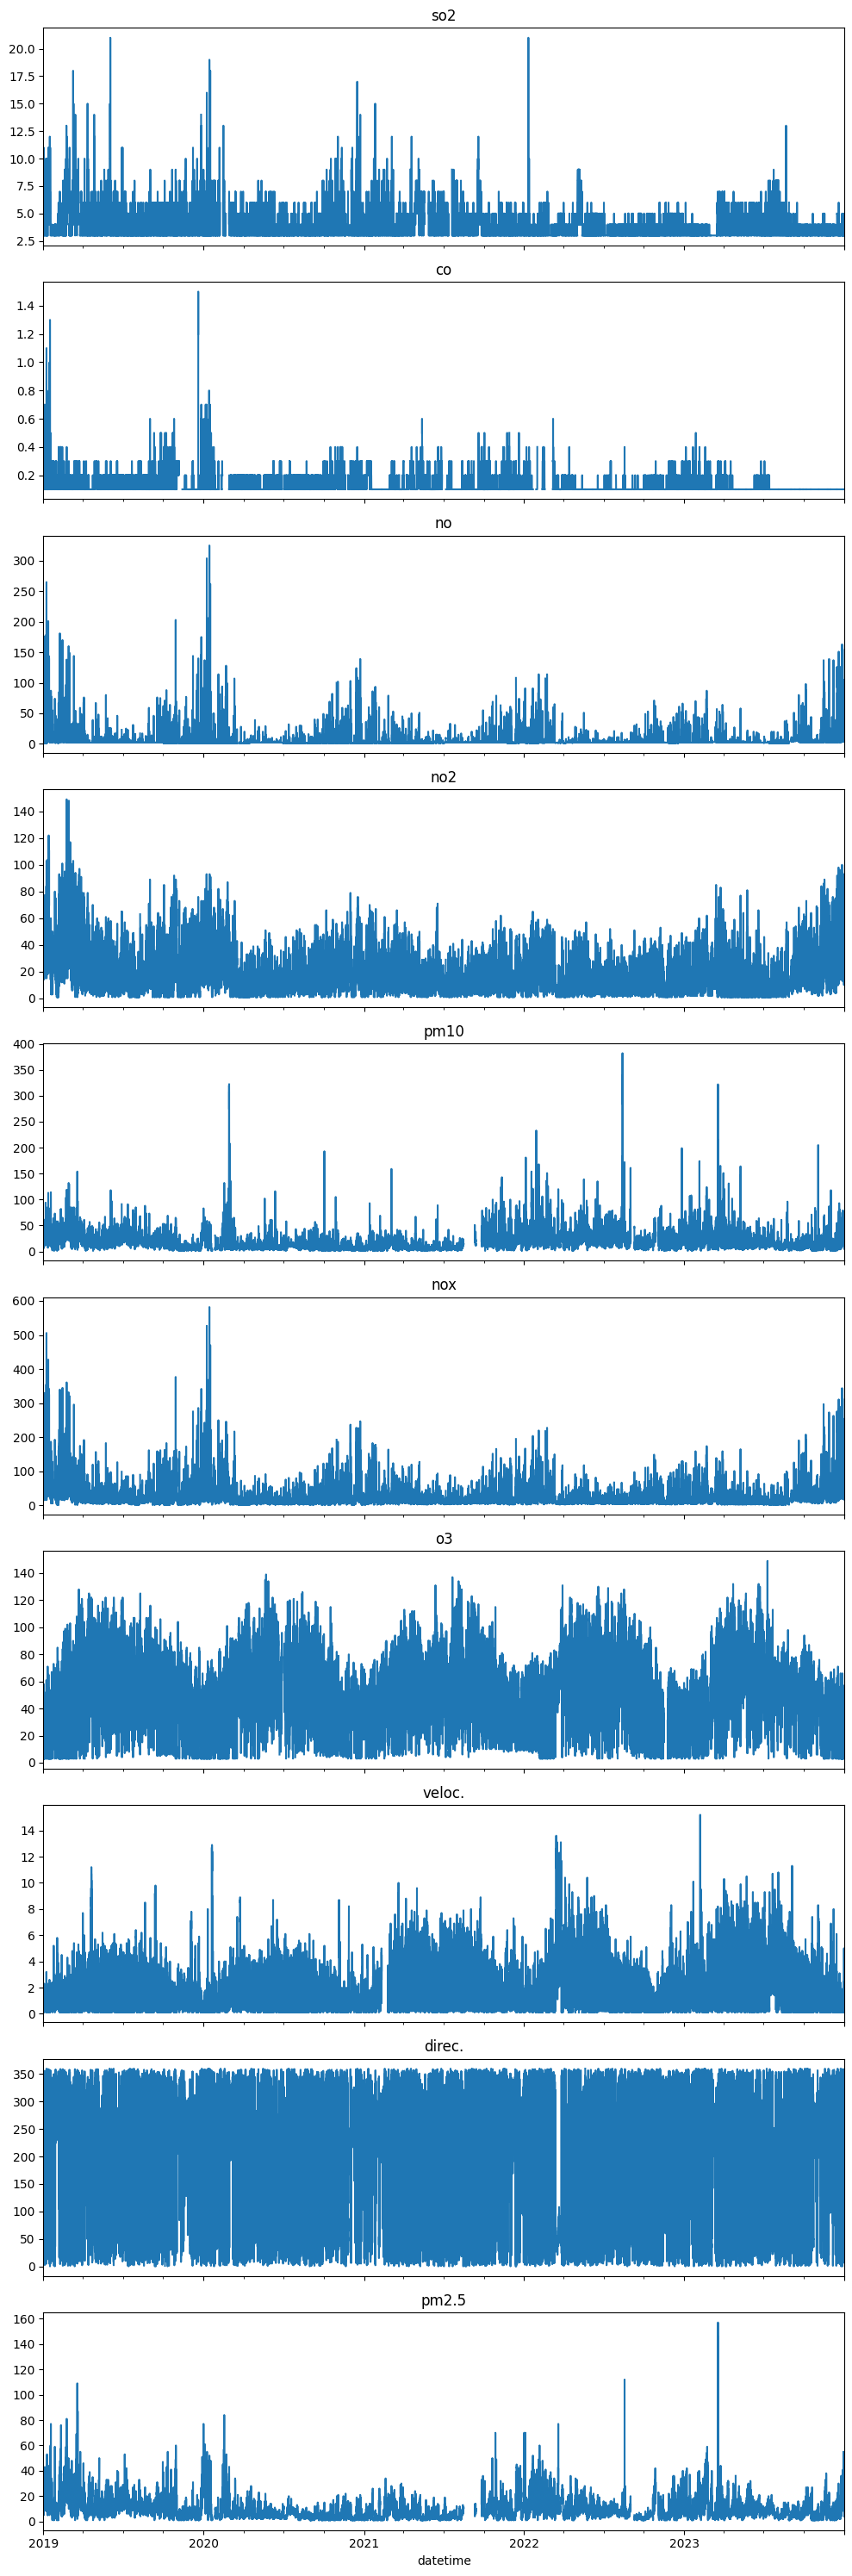

In [4]:
# Plot time series
n_cols = len(data.columns)
fig, axes = plt.subplots(nrows=n_cols, ncols=1, figsize=(10, n_cols * 3), sharex=True)

for col, ax in zip(data.columns, axes):
    data[col].plot(ax=ax)
    ax.set_title(col)

plt.tight_layout()

In [5]:
# Impute missing values with forward filling
data = data.ffill()

Let's add the day of the week and hour of day to use as an exogenous feature.

In [6]:
data["day_of_week"] = data.index.weekday
data["hour"] = data.index.hour

Linear models can better capture seasonality using cyclical features or fourier features. 

In [7]:
from feature_engine.creation import CyclicalFeatures

See more details about this transformer and cyclical features [here](https://feature-engine.trainindata.com/en/latest/api_doc/creation/CyclicalFeatures.html).

In [8]:
trafo = CyclicalFeatures(variables=["day_of_week", "hour"])
result = trafo.fit_transform(data[["day_of_week", "hour"]])
result.head()

,day_of_week,hour,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
datetime,,,,,,
2019-01-01 00:00:00,1,0,0.866025,0.5,0.000000,1.000000
2019-01-01 01:00:00,1,1,0.866025,0.5,0.269797,0.962917
2019-01-01 02:00:00,1,2,0.866025,0.5,0.519584,0.854419
2019-01-01 03:00:00,1,3,0.866025,0.5,0.730836,0.682553
2019-01-01 04:00:00,1,4,0.866025,0.5,0.887885,0.460065


In [9]:
data = trafo.fit_transform(data)
data.head()

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5,day_of_week,hour,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0,1,0,0.866025,0.5,0.000000,1.000000
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0,1,1,0.866025,0.5,0.269797,0.962917
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0,1,2,0.866025,0.5,0.519584,0.854419
2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0,1,3,0.866025,0.5,0.730836,0.682553
2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0,1,4,0.866025,0.5,0.887885,0.460065


## Multivariate forecasting

In [10]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Multiple dependent series forecasting (Direct)
from skforecast.direct import ForecasterDirectMultiVariate

![image](./images/forecaster_multivariate_train_matrix_diagram.png)

Image from [skforecast documentation](https://skforecast.org/0.11.0/user_guides/dependent-multi-series-multivariate-forecasting)

In [11]:
forecast_target = "co"

# Define the forecaster
forecaster = ForecasterDirectMultiVariate(
    regressor=Ridge(alpha=1),
    level=forecast_target,
    lags=24,
    steps=24,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

In [12]:
# Time series variables
variables = air_pollutants + ["veloc.", "direc."]

# Exogenous feature column names
exog_cols = ["hour_sin", "hour_cos", "day_of_week_sin", "day_of_week_cos"]

X_train, y_train = forecaster.create_train_X_y(
    series=data[variables], exog=data[exog_cols]
)

In [13]:
X_train.columns.values

array(['pm2.5_lag_1', 'pm2.5_lag_2', 'pm2.5_lag_3', 'pm2.5_lag_4',
       'pm2.5_lag_5', 'pm2.5_lag_6', 'pm2.5_lag_7', 'pm2.5_lag_8',
       'pm2.5_lag_9', 'pm2.5_lag_10', 'pm2.5_lag_11', 'pm2.5_lag_12',
       'pm2.5_lag_13', 'pm2.5_lag_14', 'pm2.5_lag_15', 'pm2.5_lag_16',
       'pm2.5_lag_17', 'pm2.5_lag_18', 'pm2.5_lag_19', 'pm2.5_lag_20',
       'pm2.5_lag_21', 'pm2.5_lag_22', 'pm2.5_lag_23', 'pm2.5_lag_24',
       'co_lag_1', 'co_lag_2', 'co_lag_3', 'co_lag_4', 'co_lag_5',
       'co_lag_6', 'co_lag_7', 'co_lag_8', 'co_lag_9', 'co_lag_10',
       'co_lag_11', 'co_lag_12', 'co_lag_13', 'co_lag_14', 'co_lag_15',
       'co_lag_16', 'co_lag_17', 'co_lag_18', 'co_lag_19', 'co_lag_20',
       'co_lag_21', 'co_lag_22', 'co_lag_23', 'co_lag_24', 'no_lag_1',
       'no_lag_2', 'no_lag_3', 'no_lag_4', 'no_lag_5', 'no_lag_6',
       'no_lag_7', 'no_lag_8', 'no_lag_9', 'no_lag_10', 'no_lag_11',
       'no_lag_12', 'no_lag_13', 'no_lag_14', 'no_lag_15', 'no_lag_16',
       'no_lag_17', 'no_l

In [14]:
X_train.head()

,pm2.5_lag_1,pm2.5_lag_2,pm2.5_lag_3,pm2.5_lag_4,pm2.5_lag_5,pm2.5_lag_6,pm2.5_lag_7,pm2.5_lag_8,pm2.5_lag_9,pm2.5_lag_10,...,day_of_week_sin_step_22,day_of_week_cos_step_22,hour_sin_step_23,hour_cos_step_23,day_of_week_sin_step_23,day_of_week_cos_step_23,hour_sin_step_24,hour_cos_step_24,day_of_week_sin_step_24,day_of_week_cos_step_24
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-02 23:00:00,2.720222,3.199597,2.121005,0.802725,0.563038,0.563038,0.323351,-0.036179,0.083664,0.443195,...,1.322514e+00,-0.865472,-3.897566e-01,1.278655,1.322514e+00,-0.865472,-3.469813e-16,1.330124,1.322514e+00,-0.865472
2019-01-03 00:00:00,2.001161,2.720222,3.199597,2.121005,0.802725,0.563038,0.563038,0.323351,-0.036179,0.083664,...,1.322514e+00,-0.865472,-3.469813e-16,1.330124,1.322514e+00,-0.865472,6.851107e-18,1.330124,2.704573e-16,-1.539109
2019-01-03 01:00:00,1.641630,2.001161,2.720222,3.199597,2.121005,0.802725,0.563038,0.563038,0.323351,-0.036179,...,1.322514e+00,-0.865472,6.851107e-18,1.330124,2.704573e-16,-1.539109,3.897566e-01,1.278655,2.704573e-16,-1.539109
2019-01-03 02:00:00,0.802725,1.641630,2.001161,2.720222,3.199597,2.121005,0.802725,0.563038,0.563038,0.323351,...,2.704573e-16,-1.539109,3.897566e-01,1.278655,2.704573e-16,-1.539109,7.506067e-01,1.128065,2.704573e-16,-1.539109
2019-01-03 03:00:00,0.802725,0.802725,1.641630,2.001161,2.720222,3.199597,2.121005,0.802725,0.563038,0.563038,...,2.704573e-16,-1.539109,7.506067e-01,1.128065,2.704573e-16,-1.539109,1.055788e+00,0.889522,2.704573e-16,-1.539109


In [15]:
y_train

{1: datetime
 2019-01-02 00:00:00    1.071171
 2019-01-02 01:00:00    1.071171
 2019-01-02 02:00:00    2.563463
 2019-01-02 03:00:00   -0.421120
 2019-01-02 04:00:00   -0.421120
                          ...   
 2023-12-30 20:00:00   -0.421120
 2023-12-30 21:00:00   -0.421120
 2023-12-30 22:00:00   -0.421120
 2023-12-30 23:00:00   -0.421120
 2023-12-31 00:00:00   -0.421120
 Freq: h, Name: co_step_1, Length: 43777, dtype: float64,
 2: datetime
 2019-01-02 01:00:00    1.071171
 2019-01-02 02:00:00    2.563463
 2019-01-02 03:00:00   -0.421120
 2019-01-02 04:00:00   -0.421120
 2019-01-02 05:00:00   -0.421120
                          ...   
 2023-12-30 21:00:00   -0.421120
 2023-12-30 22:00:00   -0.421120
 2023-12-30 23:00:00   -0.421120
 2023-12-31 00:00:00   -0.421120
 2023-12-31 01:00:00   -0.421120
 Freq: h, Name: co_step_2, Length: 43777, dtype: float64,
 3: datetime
 2019-01-02 02:00:00    2.563463
 2019-01-02 03:00:00   -0.421120
 2019-01-02 04:00:00   -0.421120
 2019-01-02 05:00:00

In [16]:
# Forecast horizon: Number of steps to predict
steps = 24

# Prepare exogenous features for the future
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=steps + 1)

future_exog = pd.DataFrame(index=future_dates)
future_exog["hour"] = future_exog.index.hour
future_exog["day_of_week"] = future_exog.index.weekday
future_exog = trafo.fit_transform(future_exog)
future_exog

,hour,day_of_week,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2024-01-01 00:00:00,0,0,0.000000e+00,1.0,0.000000e+00,1.000000
2024-01-01 01:00:00,1,0,0.000000e+00,1.0,2.697968e-01,0.962917
2024-01-01 02:00:00,2,0,0.000000e+00,1.0,5.195840e-01,0.854419
2024-01-01 03:00:00,3,0,0.000000e+00,1.0,7.308360e-01,0.682553
2024-01-01 04:00:00,4,0,0.000000e+00,1.0,8.878852e-01,0.460065
2024-01-01 05:00:00,5,0,0.000000e+00,1.0,9.790841e-01,0.203456
2024-01-01 06:00:00,6,0,0.000000e+00,1.0,9.976688e-01,-0.068242
2024-01-01 07:00:00,7,0,0.000000e+00,1.0,9.422609e-01,-0.334880
2024-01-01 08:00:00,8,0,0.000000e+00,1.0,8.169699e-01,-0.576680
2024-01-01 09:00:00,9,0,0.000000e+00,1.0,6.310879e-01,-0.775711


In [17]:
# Fit the model
forecaster.fit(series=data[variables], exog=data[exog_cols])

# Forecast
forecast = forecaster.predict(steps=steps, exog=future_exog[exog_cols])
forecast

,co
2024-01-01 00:00:00,0.100817
2024-01-01 01:00:00,0.103589
2024-01-01 02:00:00,0.107095
2024-01-01 03:00:00,0.107073
2024-01-01 04:00:00,0.106401
2024-01-01 05:00:00,0.106198
2024-01-01 06:00:00,0.105998
2024-01-01 07:00:00,0.105199
2024-01-01 08:00:00,0.104360
2024-01-01 09:00:00,0.107593


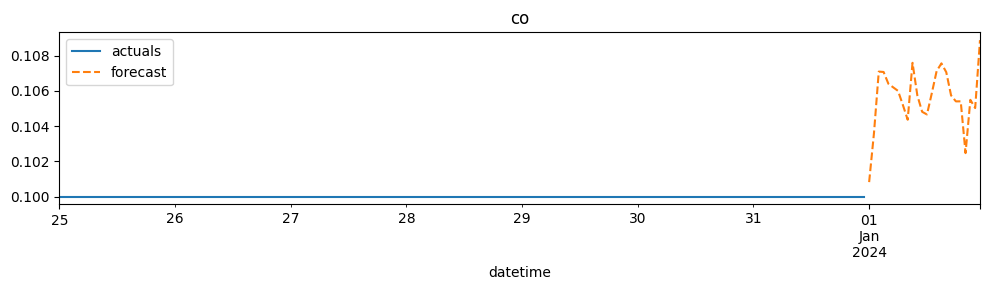

In [18]:
# Plot forecast
fig, ax = plt.subplots(figsize=[10, 3])
data.iloc[-7 * 24 :][forecast_target].plot(ax=ax, label="actuals")
forecast.loc[:, forecast_target].plot(ax=ax, linestyle="--", label="forecast")
ax.legend()
ax.set_title(f"{forecast_target}")

plt.tight_layout()

In [19]:
# Feature importance
forecaster.get_feature_importances(step=1)

,feature,importance
24,co_lag_1,0.711130
137,nox_lag_18,0.186984
124,nox_lag_5,0.181194
67,no_lag_20,0.146843
141,nox_lag_22,0.143908
...,...,...
131,nox_lag_12,-0.149658
123,nox_lag_4,-0.154409
140,nox_lag_21,-0.169807
127,nox_lag_8,-0.190389


<Axes: xlabel='feature'>

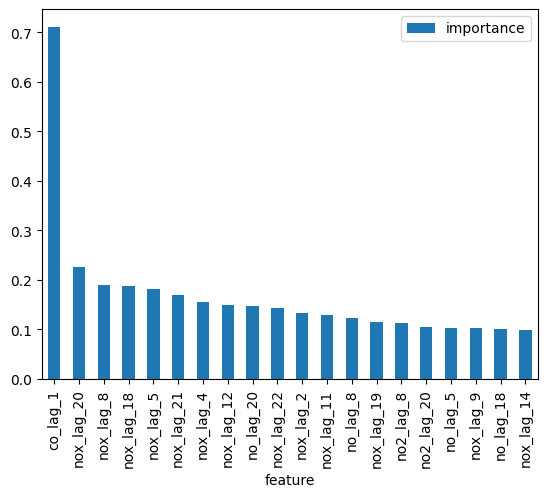

In [20]:
# Plot feature importance
(
    forecaster.get_feature_importances(step=1)
    .assign(importance=lambda df: np.abs(df.importance))
    .set_index("feature")
    .nlargest(20, columns=["importance"])
).plot(kind="bar")

In [21]:
# See more details here: https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/probabilistic-forecasting.html

forecast_intervals = forecaster.predict_interval(
    steps=steps,
    exog=future_exog[exog_cols],
)
forecast_intervals.head(3)

,co,co_lower_bound,co_upper_bound
2024-01-01 00:00:00,0.100817,0.032044,0.151494
2024-01-01 01:00:00,0.103589,0.037728,0.191817
2024-01-01 02:00:00,0.107095,0.042950,0.189743


Let's bring it all together and forecast all the time series

In [22]:
# Variables
variables = air_pollutants + ["veloc.", "direc."]

# Exogenous feature column names
exog_cols = ["hour_sin", "hour_cos", "day_of_week_sin", "day_of_week_cos"]

# Forecast horizon: Number of steps to predict
steps = 24

# Prepare exogenous features for the future
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=steps + 1)

future_exog = pd.DataFrame(index=future_dates)
future_exog["hour"] = future_exog.index.hour
future_exog["day_of_week"] = future_exog.index.weekday
future_exog = trafo.fit_transform(future_exog)

# Loop over each pollutant
results = []
models = dict()

for pollutant in air_pollutants:

    # Define the forecaster
    forecaster = ForecasterDirectMultiVariate(
        regressor=Ridge(alpha=1),
        level=pollutant,
        lags=24,
        steps=24,
        transformer_series=StandardScaler(),
        transformer_exog=StandardScaler(),
    )

    # Fit the model
    forecaster.fit(series=data[variables], exog=data[exog_cols])

    # Forecast
    forecast = forecaster.predict(steps=steps, exog=future_exog[exog_cols])

    models[pollutant] = forecaster
    results.append(forecast)

forecasts = pd.concat(results, axis=1)

In [23]:
forecasts

,pm2.5,co,no,no2,pm10,nox,o3,so2
2024-01-01 00:00:00,6.147252,0.100817,5.228215,17.782458,8.303634,25.541374,45.537549,3.153108
2024-01-01 01:00:00,7.829061,0.103589,4.671821,21.018215,10.432674,28.009735,39.313174,3.305380
2024-01-01 02:00:00,8.226283,0.107095,4.221130,20.950760,11.298826,27.191545,36.577762,3.385840
2024-01-01 03:00:00,8.394889,0.107073,2.878041,19.599703,12.197880,23.860006,36.710829,3.417573
2024-01-01 04:00:00,8.040636,0.106401,2.003196,16.652229,12.294054,19.552299,38.803636,3.457976
2024-01-01 05:00:00,7.386987,0.106198,2.097407,14.062618,11.754685,17.170379,40.905541,3.521458
2024-01-01 06:00:00,6.889579,0.105998,2.543385,13.114885,12.005173,16.822467,41.896486,3.514213
2024-01-01 07:00:00,6.613613,0.105199,3.746675,12.747471,12.908824,18.413053,43.096254,3.569059
2024-01-01 08:00:00,6.329264,0.104360,5.465953,13.781500,14.073212,22.011091,43.119083,3.618701
2024-01-01 09:00:00,6.587641,0.107593,7.655435,14.772972,15.446711,26.403805,43.473683,3.590535


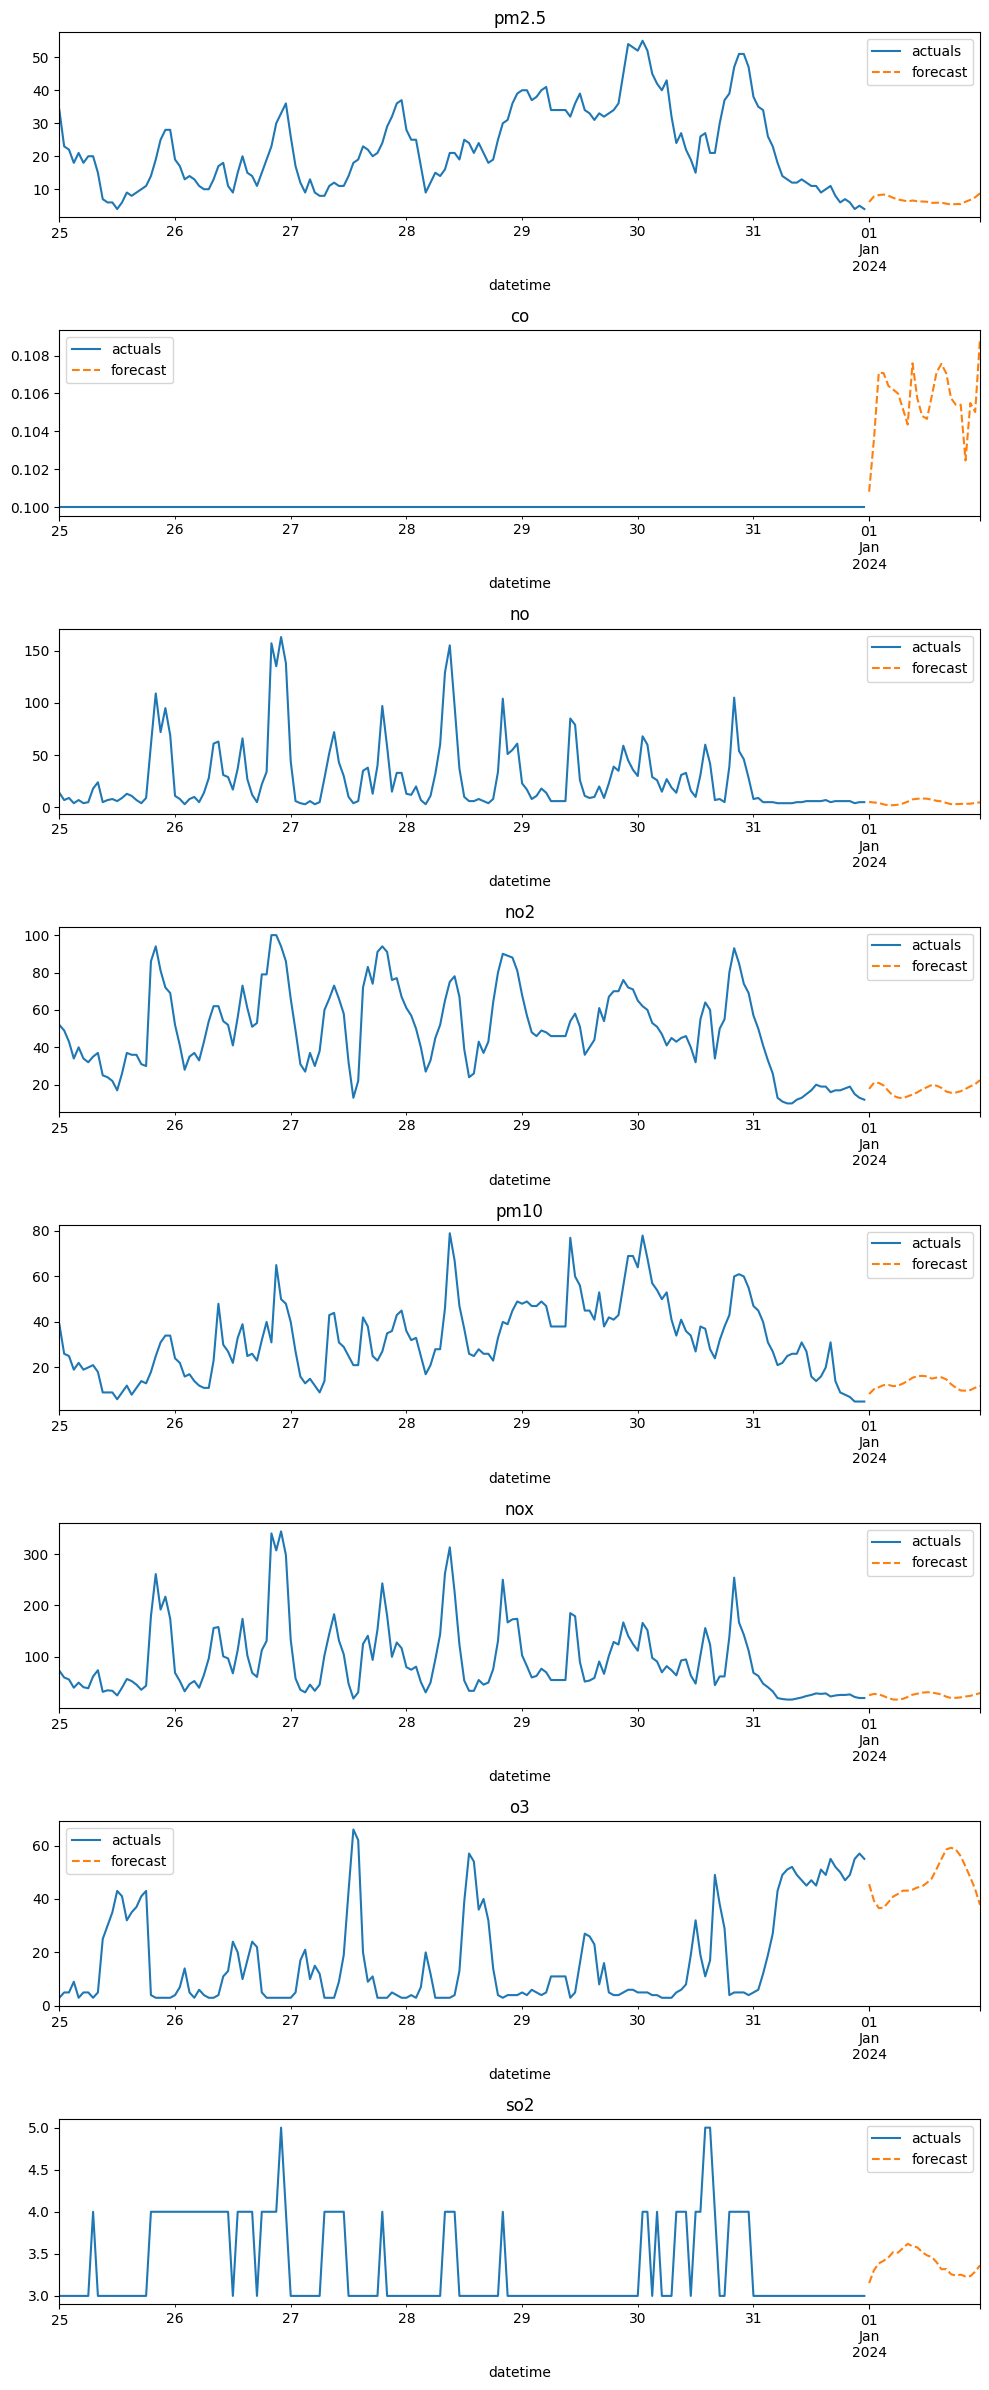

In [24]:
# Plotting
num_timeseries = len(air_pollutants)
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries])
for pollutant, ax in zip(air_pollutants, axs):

    data.iloc[-24 * 7 :][pollutant].plot(ax=ax, label="actuals")
    forecasts.loc[:, pollutant].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{pollutant}")

plt.tight_layout()